In [1]:
from __future__ import print_function
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.layers import Input, Flatten, Dense

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

import random
from keras import ops

from Data import Data
from CreateModel import ModelCreate

2024-06-30 20:53:15.260184: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-30 20:53:15.305381: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 20:53:15.976246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 

In [2]:
epochs = 40
batch_size = 32
margin = 1  # Margin for contrastive loss.

In [3]:
base_path = '/home/aacastro/Alejandro/DQ_ACA_2024/A/ZN_1D_imgs/orig/'
data_processor = Data(base_path)
X, Y, ass_f, ass_l = data_processor.get_data('train.npz', 'validation.npz', 'test.npz', 'assess.npz')
print(X.shape)

(4482, 264, 18)


In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", Y_train.shape)
print("Forma de y_test:", Y_test.shape)

Forma de X_train: (3585, 264, 18)
Forma de X_test: (897, 264, 18)
Forma de y_train: (3585, 2)
Forma de y_test: (897, 2)


In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
ass_f = ass_f.astype('float32')
X_train /= 255
X_test /= 255
ass_f /= 255

In [6]:
# Keep 75% of train_val in validation set
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
Y_test = np.argmax(Y_test, axis=1)
# ass_l = np.argmax(ass_l, axis=1)

del X_train, Y_train

In [7]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")

In [8]:
# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# # make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# # make test pairs
pairs_test, labels_test = make_pairs(X_test, Y_test)

# make ass pairs
# pairs_ass, labels_ass = make_pairs(ass_f, ass_l)

In [9]:
# print("Forma de las parejas de entrenamiento:", pairs_train.shape)
# print("Forma de las parejas de validación:", pairs_val.shape)
# print("Forma de las parejas de test:", pairs_test.shape)
# # print("Forma de las parejas de assess:", pairs_ass.shape)

In [10]:
x_train_1 = pairs_train[:, 0] 
x_train_2 = pairs_train[:, 1]

x_val_1 = pairs_val[:, 0]  
x_val_2 = pairs_val[:, 1]

x_test_1 = pairs_test[:, 0]
x_test_2 = pairs_test[:, 1]

# x_ass_1 = pairs_ass[:, 0]
# x_ass_2 = pairs_ass[:, 1]

In [11]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(ops.concatenate([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

In [12]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))

In [13]:
yaml_path = '/home/aacastro/Alejandro/DQ_ACA_2024/C/models.yaml'
Model = ModelCreate(yaml_path)
models = Model.create_models()

model = models[0][1]
model.summary()

2024-06-30 20:53:18.296790: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 20:53:18.343372: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 20:53:18.344991: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 264, 18)        │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 264, 16)        │         1,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 132, 16)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 132, 16)        │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 66, 16)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1056)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1056)           │         4,224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     2,164,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,171,784 (8.28 MB)

 Trainable params: 2,169,636 (8.28 MB)

 Non-trainable params: 2,148 (8.39 KB)

In [14]:
embedding_network = model

input_1 = keras.layers.Input((264, 18))
input_2 = keras.layers.Input((264, 18))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

# merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
#     [tower_1, tower_2]
# )
merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)

normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [15]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - (y_pred), 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

In [16]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 264, 18)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 264, 18)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 2048)      │  2,171,784 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,171,790 (8.28 MB)

 Trainable params: 2,169,640 (8.28 MB)

 Non-trainable params: 2,150 (8.40 KB)

In [17]:
# Esta celda sirve para que, en vista de que el modelo con el mismo codigo unas veces aprendía y otras no, 
# una vez que aprendió guardé sus  datos de entrenamiento y validación, a ver si podía venir por ahí el problema. 
# Aunque se carguen las mismas parejas para entrenar y validar, no se obtienen los mismos resultados.
# La red sigue aprendiendo unas veces si y otras no (la amplísima mayoria)


# x_train_1 = np.load('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/x_train_1.npy')
# x_train_2 = np.load('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/x_train_2.npy')
# labels_train = np.load('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/labels_train.npy')

# x_val_1 = np.load('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/x_val_1.npy')
# x_val_2 = np.load('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/x_val_2.npy')
# labels_val = np.load('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/labels_val.npy')

# x_test_1 = np.load('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/x_test_1.npy')
# x_test_2 = np.load('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/x_test_2.npy')
# labels_test = np.load('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/labels_test.npy')

In [18]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/40


I0000 00:00:1719773600.874600 1008684 service.cc:145] XLA service 0x7ff5fc00b770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719773600.875736 1008684 service.cc:153]   StreamExecutor device (0): NVIDIA A30, Compute Capability 8.0
2024-06-30 20:53:20.913566: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-30 20:53:21.111431: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-06-30 20:53:23.697546: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 73/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4847 - loss: 0.2502

I0000 00:00:1719773604.267743 1008684 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.4939 - loss: 0.2502 - val_accuracy: 0.5000 - val_loss: 0.2505
Epoch 2/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5048 - loss: 0.2516 - val_accuracy: 0.5000 - val_loss: 0.2536
Epoch 3/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5123 - loss: 0.2521 - val_accuracy: 0.5014 - val_loss: 0.2547
Epoch 4/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5132 - loss: 0.2550 - val_accuracy: 0.4986 - val_loss: 0.2506
Epoch 5/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5132 - loss: 0.2512 - val_accuracy: 0.5000 - val_loss: 0.2518
Epoch 6/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5123 - loss: 0.2505 - val_accuracy: 0.5160 - val_loss: 0.2549
Epoch 7/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4985 - loss: 0.2509 - val_accuracy: 0.5000 - val_loss: 0.2547
Epoch 8/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5101 - loss: 0.2501 - val_accuracy: 0.4979 - val

In [19]:
# Esta celda tiene el mismo propósito que la hace 2 anteriores.

# np.save('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/x_train_1.npy', x_train_1)
# np.save('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/x_train_2.npy', x_train_2)
# np.save('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/labels_train.npy', labels_train)

# np.save('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/x_val_1.npy', x_val_1)
# np.save('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/x_val_2.npy', x_val_2)
# np.save('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/labels_val.npy', labels_val)

# np.save('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/x_test_1.npy', x_test_1)
# np.save('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/x_test_2.npy', x_test_2)
# np.save('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/data_train_CL/labels_test.npy', labels_test)

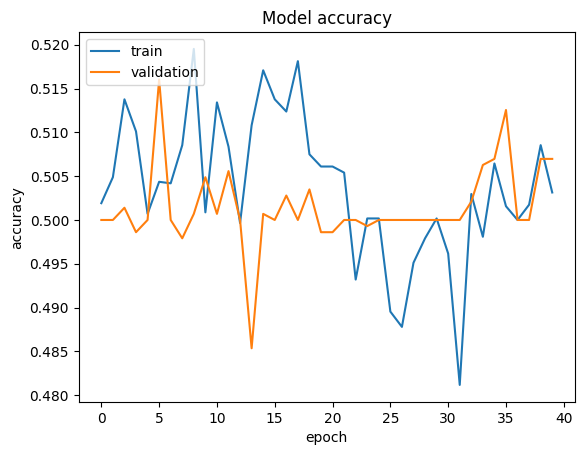

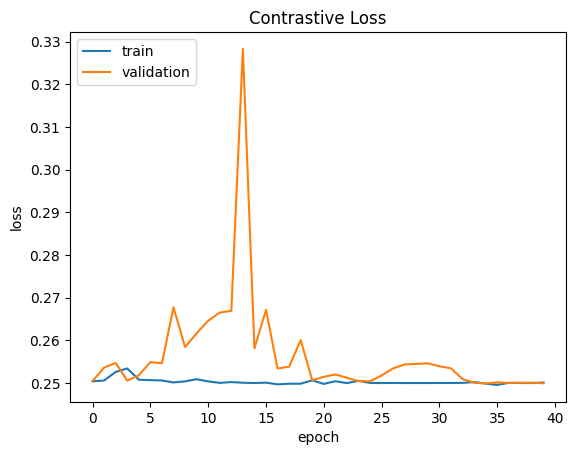

In [20]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

In [21]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5004 - loss: 0.2501
test loss, test acc: [0.25005456805229187, 0.5005574226379395]


En esta celda traté de modificar cómo se definía si una imagen se clasificaba en una clase u otra. 

En el cuaderno original, se calculaba la media de las similaridades entre la imagen entrante y las 5 de referencia de cada clase. Se calculaba la media de las similaridades para cada clase y se asignaba en función de cual fuera menor.

Para variar este enfoque, decidí probar a que se asignara la imagen a la clase en la que hubiera una única probabilidad más baja. De esta forma con que la imagen entrante se parezca mucho a unicamente a una de las 10 de referencia (5 y 5) se asignará a esa clase. Esto es porque ne vista de que hay varios clusters por cada clase, podía parecerse mucho a uno y poco a otro y que con la media se anulase. Entonces en la clase en la que esté el mínimo se asigna a esa.



Posteriormente se prueba a hacer la clasificación del conjunto gold standard con las imagenes de referencia obtenidas usando la distancia de manhattan y luego la de yule. Los resultados son muy parecidos entre ellas. O más curioso aún, la similaridad de la imagen entrante con las imágenes de referencia de OK y NOK ¡¡¡es la misma!!! 

Esto último no parece en realidad relevante ya que al no estar aprendiendo la red, los resultados no tienen demasiado valor. Aunque aún en ocasiones en los que la red aprendia había imágenes que daban la misma similaridad para la clase 0 y 1.

In [22]:
# Función para calcular la similitud utilizando la red siamesa
def calculate_similarity(model, img1, img2):
    """
    Calculates the similarity between two images using a siamese network model.

    Args:
        model (keras.Model): The pre-trained siamese network model.
        img1 (numpy.ndarray): The first image for similarity calculation.
        img2 (numpy.ndarray): The second image for similarity calculation.

    Returns:
        float: The similarity score between img1 and img2.
    """
    img1 = np.expand_dims(img1, axis=0)
    img2 = np.expand_dims(img2, axis=0)
    return model.predict([img1, img2])[0][0]

# Función para clasificar una nueva imagen
def classify_image(model, img, reference_images_class0, reference_images_class1):
    """
    Classifies a single image by comparing it to reference images from two classes.

    Args:
        model (keras.Model): The pre-trained siamese network model.
        img (numpy.ndarray): The image to be classified.
        reference_images_class0 (list of numpy.ndarray): List of reference images for class 0.
        reference_images_class1 (list of numpy.ndarray): List of reference images for class 1.

    Returns:
        int: The predicted class label (0 or 1).
    """
    similarities_class0 = [calculate_similarity(model, img, ref_img) for ref_img in reference_images_class0]
    similarities_class1 = [calculate_similarity(model, img, ref_img) for ref_img in reference_images_class1]
    
    # mean_similarity_class0 = np.mean(similarities_class0)
    # mean_similarity_class1 = np.mean(similarities_class1)
    # Encontrar la mayor similitud individual para cada clase
    print("similarities 0: ", similarities_class0)
    print("similarities 1: ", similarities_class1)
    # print("type: ", type(similarities_class0))
    min_similarity_class0 = min(similarities_class0)
    min_similarity_class1 = min(similarities_class1)
    
    if min_similarity_class0 < min_similarity_class1:
        return 0
    else:
        return 1
    
# Función para clasificar un lote de imágenes
def classify_images(model, images, reference_images_class0, reference_images_class1):
    """
    Classifies a batch of images by comparing each image to reference images from two classes.

    Args:
        model (keras.Model): The pre-trained siamese network model.
        images (list of numpy.ndarray): List of images to be classified.
        reference_images_class0 (list of numpy.ndarray): List of reference images for class 0.
        reference_images_class1 (list of numpy.ndarray): List of reference images for class 1.

    Returns:
        numpy.ndarray: Array of predicted class labels for each image in the batch.
    """
    predictions = []
    for img in images:
        predictions.append(classify_image(model, img, reference_images_class0, reference_images_class1))
    return np.array(predictions)

In [23]:
OK_manhattan = np.load('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/OK_manhattan.npy')
NOK_manhattan = np.load('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/NOK_manhattan.npy')

# Clasificar las imágenes de prueba
predicted_labels_manhattan = classify_images(siamese, ass_f, OK_manhattan, NOK_manhattan);

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
similarities 0:  [0.44616738, 0.44616738, 0.44616738, 0.44616738, 0.44616738]
similarities 1:  [0.44618794, 0.44616738, 0.44616738, 0.44616738, 0.44616738]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
similarities 0:  [0.44616738, 0.44616738, 0.44616738, 0.44616738, 0.44616738]
simil

In [24]:
# Calcular y mostrar otras métricas
print("Reporte de Clasificación:")
print(classification_report(ass_l, predicted_labels_manhattan))

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.50      1.00      0.67        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


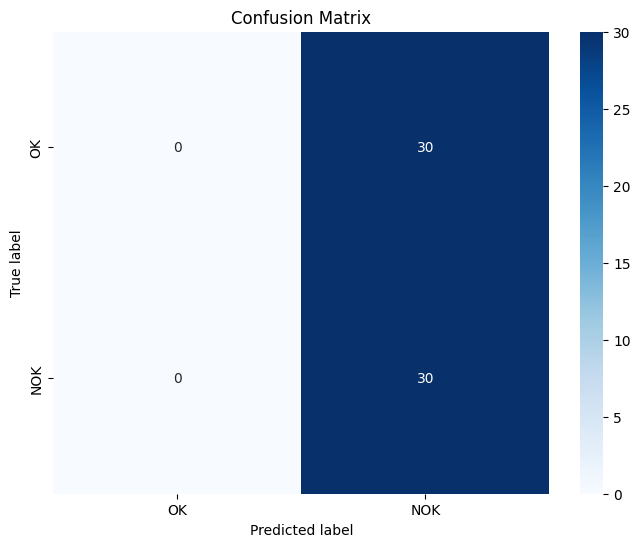

In [25]:
# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(ass_l, predicted_labels_manhattan), annot=True, fmt="d", cmap="Blues", xticklabels=['OK', 'NOK'], yticklabels=['OK', 'NOK'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
OK_yule = np.load('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/OK_yule.npy')
NOK_yule = np.load('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/NOK_yule.npy')

# Clasificar las imágenes de prueba
predicted_labels_yule = classify_images(siamese, ass_f, OK_yule, NOK_yule);

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
similarities 0:  [0.44616738, 0.44616738, 0.4469985, 0.44618794, 0.44616744]
similarities 1:  [0.44618794, 0.44616738, 0.44616738, 0.44618794, 0.44618794]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
similarities 0:  [0.44616738, 0.44616738, 0.44699845, 0.44618782, 0.44616747]
similar

In [27]:
# Calcular y mostrar otras métricas
print("Reporte de Clasificación:")
print(classification_report(ass_l, predicted_labels_yule))

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.50      1.00      0.67        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


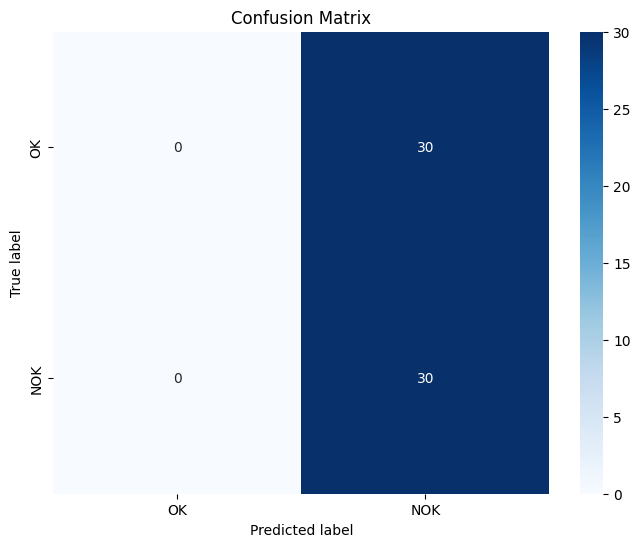

In [28]:
# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(ass_l, predicted_labels_yule), annot=True, fmt="d", cmap="Blues", xticklabels=['OK', 'NOK'], yticklabels=['OK', 'NOK'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()